<h1> Dynamic Topic Modelling using Greene and Cross code </h1>

In [1]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt
import unsupervised.nmf, unsupervised.rankings


from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

In [2]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

In [3]:
# Modify the pre-processing function
def preprocess(df, stopwords):
    # Append all the final tokens
    text = []
    docs = df['final_tokens']
    
    for abstract in docs:
        text.append(' '.join(abstract))
        
    # Create the term-document matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, lowercase=False, stop_words=stop_wds)
    tf_idf = tfidf_vectorizer.fit_transform(text)
    
    # store the vocabulary map
    v = tfidf_vectorizer.vocabulary_
    terms = []
    for i in range(len(v)):
        terms.append("")
    for term in v.keys():
        terms[ v[term] ] = term
        
    return (tf_idf,terms)

In [4]:
# Load the dataset. Apply the DTM on the coronavirus corpus (1000 abstracts)
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


<h2> Pre-processing </h2>

In [5]:
# Transform dataset as in Greene. Create a data sample for each year
time = df['FY'].unique()

for year in time:
    df_subset = df[df['FY']==year]
    
    # save the pickle file
    pickle.dump(df_subset, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(year)+'.pkl','wb'))

In [6]:
# Create the term-document matrix tfidf for each pkl file
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

for year in time:
    # Load the sample for a given year
    fw = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(year)+'.pkl', 'rb')
    dfw = pickle.load(fw)
    fw.close()
            
    # Pre-processing the pkl file
    (tf_idf,terms) = preprocess(dfw, stop_wds)
    
    # Save the term-document matrix
    joblib.dump((tf_idf,terms,df), '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Term_docs_'+str(year)+'.pkl' )

In [7]:
# build the dictionary id2word
docs = df["final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

<h2> Window Topic Modeling </h2>

In [8]:
# solve for NMF by windows topic.
# For each windows the number of topics is between 10 to 60
!python find-window-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/*.pkl -k 10,40 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out


Using random seed 1000
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached.

In [9]:
# Compute the coherence for topics in each topic windows
krange = list(range(10,41,5))
#skip = [[37, 2008], [39, 2008], [45, 2008], [46, 2008], [24, 2013],[27, 2013]]
skip = []
time_topic_coherence = []

for t in time:
    time_coherence=[]
    
    for k in krange:
        s = int(k)
        d = int(t)
        search = [s,d]
        
        #print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k%s.pkl' %(d,s))
        window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k%s.pkl' %(d,s))
        window_k = len(window_res[2])
        window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
        # compute the coherence
        try:
            cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
            time_coherence.append(cm.get_coherence())
        except:
            cm=0
            time_coherence.append(cm)
            pass
    time_topic_coherence.append(time_coherence)
    print('---- coherence computation ended ------')
    

---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------
---- coherence computation ended ------


In [10]:
# Select the number of topics that maximise the coherence in the first stage
topic_windows = []
coherence_windows = []
for t in range(0,len(time)):
    coherence = time_topic_coherence[t]
    max_coherence = numpy.nanmax(coherence)
    index = coherence.index(max_coherence)
    topic_windows.append(krange[index])
    coherence_windows.append(max_coherence)

print('The number of topics for each window period is:', topic_windows)

The number of topics for each window period is: [30, 15, 20, 25, 20, 25, 35, 10, 20, 15, 20, 10]


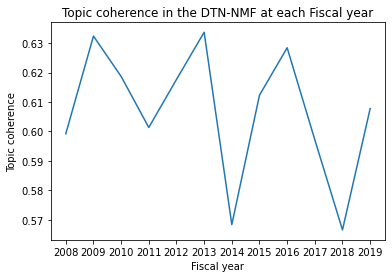

In [11]:
# plot the maximimum coherence over the fiscal year
coherence_windows_ts = pd.Series(coherence_windows, index =time)
plt.plot(coherence_windows_ts)
plt.title('Topic coherence in the DTN-NMF at each Fiscal year')
plt.xlabel("Fiscal year")
plt.ylabel("Topic coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Green_Cross_graph/Coherence_first_step.png')

<h2> Dynamic Topic Modeling </h2>

In [12]:
# Solve the dynamic topic modelling using the optimal number of topic in the first step
!python find-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k35.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k10.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k10.pkl -k 10,40 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out


Using random seed 1000
- Processing individual time window topic models ...
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded 15 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl
Loaded 20 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl
Loaded 25 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl
Loaded 20 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl
Loaded 25 time wind

In [13]:
# Find the best dynamic topic model (2nd stage)
topic_coherence = []

for k in krange:
    s = int(k)
    #print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_k = len(window_res[2])
    window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
    # compute the coherence
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', processes=30)
    topic_coherence.append(cm.get_coherence())

# Choose the best dynamic topic model (maximises the 2nd step coherence)
max_coherence = numpy.nanmax(topic_coherence)
index = topic_coherence.index(max_coherence)
print('The best dynamic topic model is: ', krange[index])

The best dynamic topic model is:  20


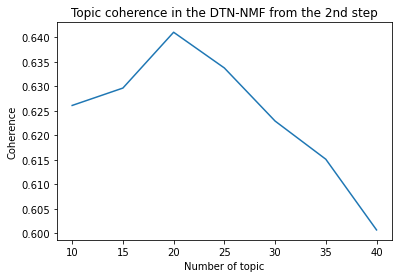

In [14]:
coherence_ts = pd.Series(topic_coherence, index =krange)
plt.plot(coherence_ts)
plt.title('Topic coherence in the DTN-NMF from the 2nd step')
plt.xlabel("Number of topic")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Green_Cross_graph/Coherence_second_step.png')

In [15]:
# Display the topic list from the NMF-DTM
!python display-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl

- Loaded model with 20 topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl
Top 10 terms for 20 topics:
+------+-----------+-----------+-------------+---------------------+-----------+------------+------------+------------+
| Rank | D01       | D02       | D03         | D04                 | D05       | D06        | D07        | D08        |
+------+-----------+-----------+-------------+---------------------+-----------+------------+------------+------------+
|    1 | virus     | influenza | mouse       | mers_cov            | fusion    | vaccine    | ace2       | immune     |
|    2 | host      | virus     | cell        | rbd                 | peptide   | vector     | receptor   | polygenic  |
|    3 | factor    | swine     | response    | bind                | entry     | attenuate  | sar_cov    | regulate   |
|    4 | species   | pandemic  | aged        | receptor            | protein   | virus      | epithelial | tra

In [48]:
# Track the dynamic
# Displays the dynamic of topic 3 (specify the -d 3 at the end of the line)
!python track-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k35.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k10.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k10.pkl -d 7


Loaded model with 20 dynamic topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded model with 15 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl
Loaded model with 20 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl
Loaded model with 25 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl
Loaded model with 20 window topics from /project/biocomplexity/sdad/projects_d

In [17]:
# Topic assignment and duplicate assignment
dynamic_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl')
dynamic_k = len(dynamic_res[2])

# Build the topic-words and limits on the top 10 words
dynamic_term_rankings = unsupervised.rankings.truncate_term_rankings( dynamic_res[2], 10 )

# Comment: All topic from the first step have 
#          This have an implication when computing the coherence
# Create a map of window topic label -> dynamic topic
assigned_window_map = {}
dynamic_partition = dynamic_res[3]
for idx, window_topic_label in enumerate(dynamic_res[0]):
    assigned_window_map[window_topic_label] = dynamic_partition[idx]
    
# Print the association
assigned_window_map

{'Term_docs_2008_01': 16,
 'Term_docs_2008_02': 1,
 'Term_docs_2008_03': 2,
 'Term_docs_2008_04': 8,
 'Term_docs_2008_05': 5,
 'Term_docs_2008_06': 8,
 'Term_docs_2008_07': 1,
 'Term_docs_2008_08': 6,
 'Term_docs_2008_09': 19,
 'Term_docs_2008_10': 9,
 'Term_docs_2008_11': 9,
 'Term_docs_2008_12': 14,
 'Term_docs_2008_13': 14,
 'Term_docs_2008_14': 17,
 'Term_docs_2008_15': 16,
 'Term_docs_2008_16': 10,
 'Term_docs_2008_17': 1,
 'Term_docs_2008_18': 19,
 'Term_docs_2008_19': 15,
 'Term_docs_2008_20': 0,
 'Term_docs_2008_21': 19,
 'Term_docs_2008_22': 4,
 'Term_docs_2008_23': 14,
 'Term_docs_2008_24': 0,
 'Term_docs_2008_25': 8,
 'Term_docs_2008_26': 18,
 'Term_docs_2008_27': 0,
 'Term_docs_2008_28': 19,
 'Term_docs_2008_29': 18,
 'Term_docs_2008_30': 11,
 'Term_docs_2009_01': 0,
 'Term_docs_2009_02': 5,
 'Term_docs_2009_03': 8,
 'Term_docs_2009_04': 17,
 'Term_docs_2009_05': 14,
 'Term_docs_2009_06': 1,
 'Term_docs_2009_07': 11,
 'Term_docs_2009_08': 4,
 'Term_docs_2009_09': 16,
 'Term

In [18]:
# Track duplicates assignment
assign_val = list(assigned_window_map.values())
i = 0
kupd = []

for chunk in topic_windows:
    kupd.append(assign_val[i:i+chunk])
    i += chunk
    
# Show the deduplicates assignment
dedup = [len(set(kupd[i])) for i in range(0,len(time))]
print ('Number of non-duplicated assgniment in topics per windows :', dedup)
print ('Number of duplicated assigment in topics per windows :', list(numpy.array(topic_windows) - numpy.array(dedup)))

Number of non-duplicated assgniment in topics per windows : [16, 11, 14, 16, 16, 17, 18, 9, 15, 12, 14, 10]
Number of duplicated assigment in topics per windows : [14, 4, 6, 9, 4, 8, 17, 1, 5, 3, 6, 0]


<h2> 3. Change in topics </h2>

In [64]:
# Plot the topics change in terms of distribution
dynamic_term_rankings

[['virus',
  'host',
  'factor',
  'species',
  'viral',
  'new',
  'family',
  'dengue',
  'infection',
  'crop'],
 ['influenza',
  'virus',
  'swine',
  'pandemic',
  '1918',
  'bird',
  'iav',
  'ha',
  'human',
  'strain'],
 ['mouse',
  'cell',
  'response',
  'aged',
  'disease',
  'severe',
  'cns',
  'aim',
  'infection',
  'respiratory'],
 ['mers_cov',
  'rbd',
  'bind',
  'receptor',
  'vaccine',
  'subunit',
  'protein',
  'neutralize_antibody',
  'spike',
  'dpp4'],
 ['fusion',
  'peptide',
  'entry',
  'protein',
  'membrane',
  'receptor',
  'class',
  'dv',
  'inhibitor',
  'spike'],
 ['vaccine',
  'vector',
  'attenuate',
  'virus',
  'candidate',
  'live',
  'ndv',
  'develop',
  'safe',
  'protective'],
 ['ace2',
  'receptor',
  'sar_cov',
  'epithelial',
  'entry',
  'nl63_cov',
  'lung',
  'sar',
  'nl63',
  'pulmonary'],
 ['immune',
  'polygenic',
  'regulate',
  'trait',
  'response',
  'protective',
  'immunity',
  'phenotype',
  'kinetic',
  'diverse'],
 ['inhibi

<h2> 4. Solve for assigment issue </h2>